In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 85.4 MB/s eta 0:00:00


In [2]:
import kagglehub
import shutil

In [3]:
# Download latest version
path = kagglehub.dataset_download("grogu22/wheat-leaf-rust")

print("Path to dataset files:", path)

# Define the target path where you want to store the dataset in the content folder
colab_content_path = '/content/wheat-leaf-rust'

# Move the dataset to the content folder
shutil.move(path, colab_content_path)

print("Path to dataset files:", colab_content_path)

100%|██████████| 242M/242M [00:12<00:00, 20.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grogu22/wheat-leaf-rust/versions/2
Path to dataset files: /content/wheat-leaf-rust


In [4]:
import wandb
import shutil
import yaml
import datetime
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
wandb_secret_key = 'f6b613e332f4b0aaf58430429473f05258b6d490'
wandb.login(key=wandb_secret_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jonjo-bonito. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
ROOT = Path("/content/wheat-leaf-rust/WheatLeafRust/")
TRAIN_DIR = ROOT / "train"

In [7]:
TRAIN_DIR

PosixPath('/content/wheat-leaf-rust/WheatLeafRust/train')

In [8]:
CLASSES = ["healthy", "leaf_rust"]
K = 5
EPOCHS = 12
BATCH = 16

In [9]:
run = wandb.init(
    # Set the project where this run will be logged
    project="YOLOv8-on-wheat-rust-13-06-2"
)

In [10]:
PROJECT    = "runs/kfold_wheat_leaf_rust"

In [11]:
all_imgs, all_lbls = [], []
for cls_idx, cls in enumerate(CLASSES):
    for img in (TRAIN_DIR/cls).glob("*.*"):
        if img.suffix.lower() in [".jpg",".jpeg",".png"]:
            all_imgs.append(img)
            all_lbls.append(cls_idx)

In [12]:
from PIL import Image

In [13]:
all_imgs[:5]

[PosixPath('/content/wheat-leaf-rust/WheatLeafRust/train/healthy/47.jpg'),
 PosixPath('/content/wheat-leaf-rust/WheatLeafRust/train/healthy/174.jpg'),
 PosixPath('/content/wheat-leaf-rust/WheatLeafRust/train/healthy/198.jpg'),
 PosixPath('/content/wheat-leaf-rust/WheatLeafRust/train/healthy/297.jpg'),
 PosixPath('/content/wheat-leaf-rust/WheatLeafRust/train/healthy/49.jpg')]

In [14]:
all_lbls[:5]

[0, 0, 0, 0, 0]

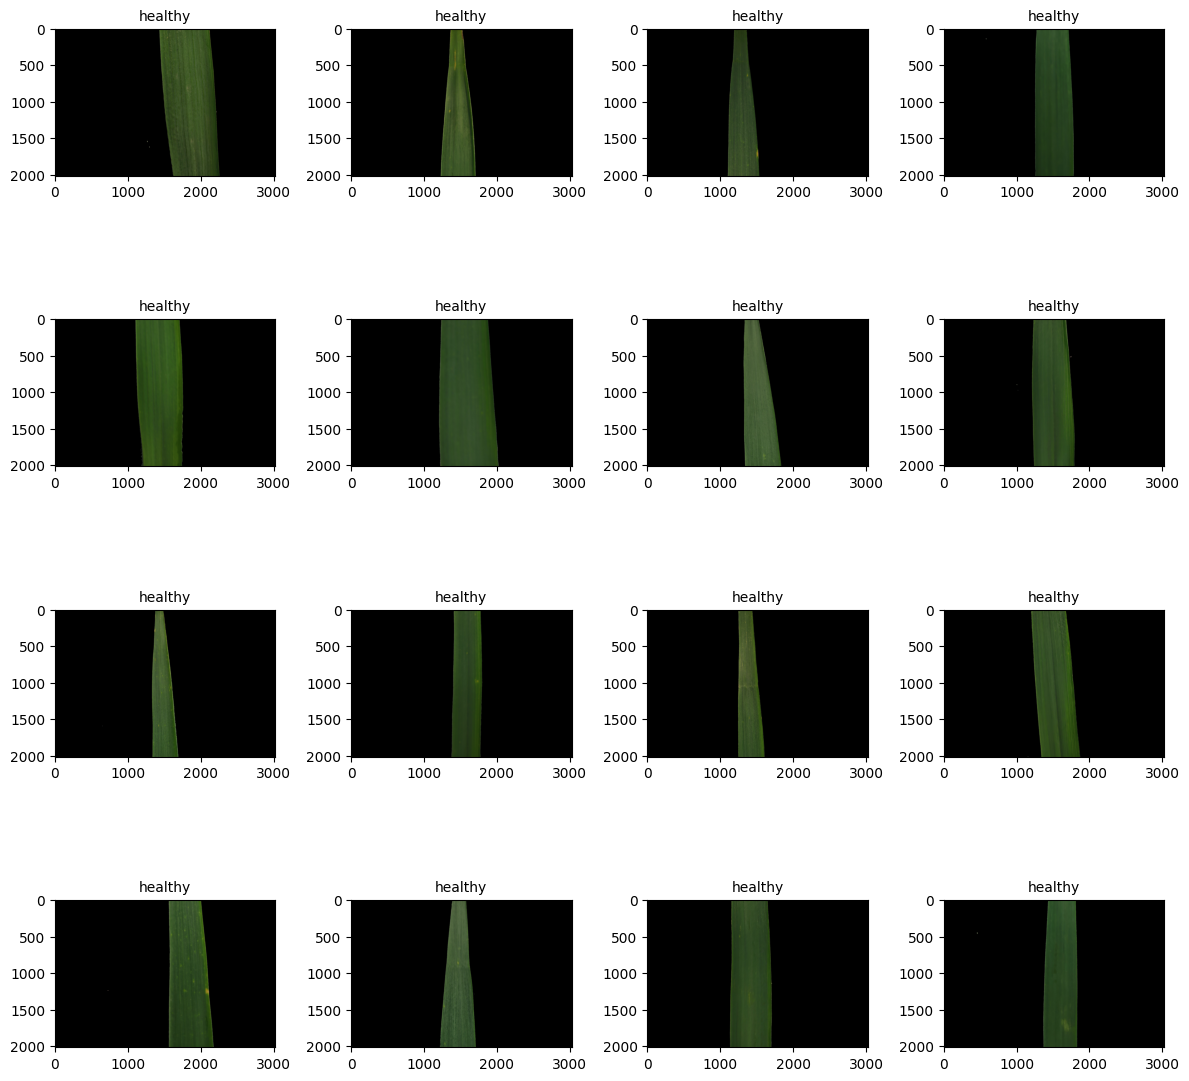

In [15]:
import matplotlib.pyplot as plt
rows, cols = 4, 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = axs.flatten()

# Prepare wandb images list for logging
wandb_images = []
import matplotlib.pyplot as plt

for i in range(rows * cols):
  ax = axs[i]
  ax.axis('off')  # Hide axis by default

  if i < 16:
    img_path = all_imgs[i]
    label = all_lbls[i]

    # Load image
    img = Image.open(img_path)

    # Show image with label as title
    ax.imshow(img)
    ax.set_title(CLASSES[label], fontsize=10)
    ax.axis('on')

    # Append to wandb images (with caption)
    wandb_images.append(wandb.Image(str(img_path), caption=CLASSES[label]))
  else:
    ax.set_visible(False)  # Hide empty subplots if less than 16

plt.tight_layout()
plt.savefig("First 16 samples.png")
plt.show()

# Log images to wandb
wandb.log({"image_grid": wandb_images})

In [16]:
# Number of samples in training dataset
len(all_imgs), len(all_lbls)

(601, 601)

In [17]:
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [18]:
splits = list(skf.split(all_imgs, all_lbls))

In [19]:
OUTPUT_DIR = Path("/content/output_dir")

In [20]:
today = datetime.date.today().isoformat()
OUT = OUTPUT_DIR / f"{today}_{K}-Fold"
OUT.mkdir(parents=True, exist_ok=True)

In [21]:
data_yaml_paths = []

for fold, (train_idx, val_idx) in enumerate(splits, start=1):
    fold_dir = OUT / f"fold_{fold}"
    # make train/val subfolders
    for split in ("train", "val"):
        for cls in CLASSES:
            (fold_dir/split/cls).mkdir(parents=True, exist_ok=True)

    # copy files
    for idx in train_idx:
        src = all_imgs[idx]
        dst = fold_dir/"train"/CLASSES[all_lbls[idx]]/src.name
        shutil.copy(src, dst)
    for idx in val_idx:
        src = all_imgs[idx]
        dst = fold_dir/"val"/CLASSES[all_lbls[idx]]/src.name
        shutil.copy(src, dst)

    # write data.yaml
    dy = {
        "path":    str(fold_dir.resolve()),
        "train":   "train",
        "val":     "val",
        "names":   CLASSES
    }
    yaml_path = fold_dir/"data.yaml"
    with open(yaml_path, "w") as f:
        yaml.safe_dump(dy, f)
    data_yaml_paths.append(str(yaml_path))

In [22]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import yaml

results = {}
for fold, dy in enumerate(data_yaml_paths, start=1):
    fold_dir = Path(dy).parent
    print(f"\n── Training fold {fold}/{K} ──")
    model = YOLO('yolov8n-cls.pt')
    res = model.train(
        data=str(fold_dir),
        epochs=EPOCHS,
        batch=BATCH,
        project=PROJECT,
        name=f"fold_{fold}"
    )
    results[f"fold_{fold}"] = res

print("\n✅ All folds trained!")


── Training fold 1/5 ──


100%|██████████| 5.31M/5.31M [00:00<00:00, 328MB/s]


Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output_dir/2025-06-12_5-Fold/fold_1, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fold_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

100%|██████████| 5.35M/5.35M [00:00<00:00, 474MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3022.8±552.9 MB/s, size: 392.9 KB)


train: Scanning /content/output_dir/2025-06-12_5-Fold/fold_1/train... 480 images, 0 corrupt: 100%|██████████| 480/480 [00:00<00:00, 2911.97it/s]

train: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_1/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2512.4±2280.6 MB/s, size: 388.8 KB)


val: Scanning /content/output_dir/2025-06-12_5-Fold/fold_1/val... 121 images, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 2343.10it/s]

val: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_1/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/kfold_wheat_leaf_rust/fold_1
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/12     0.225G     0.6789         16        224:   3%|▎         | 1/30 [00:03<01:50,  3.81s/it]Thread-40 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12      0.23G     0.6559         16        224:   7%|▋         | 2/30 [00:03<00:45,  1.64s/it]Thread-41 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12      0.23G     0.6619         16        224:  10%|█         | 3/30 [00:04<00:25,  1.07it/s]:
Traceback (most recent call last):


                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 72.64it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


       3/12     0.254G     0.3271         16        224:   0%|          | 0/30 [00:00<?, ?it/s]Exception in thread Thread-44 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.254G     0.1924         16        224:   7%|▋         | 2/30 [00:00<00:07,  3.87it/s]Thread-45 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.254G     0.1803         16        224:   7%|▋         | 2/30 [00:00<00:07,  3.87it/s]Exception in thread Threa

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 69.94it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 112.11it/s]

                   all      0.959          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 64.08it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 96.50it/s]


                   all      0.992          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 96.21it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 114.00it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.254G    0.09823         16        224: 100%|██████████| 30/30 [00:05<00:00,  5.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 74.30it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.254G    0.08784         16        224: 100%|██████████| 30/30 [00:06<00:00,  4.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 74.84it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.254G    0.07986         16        224: 100%|██████████| 30/30 [00:06<00:00,  4.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 85.55it/s]

                   all          1          1



12 epochs completed in 0.023 hours.
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_1/weights/last.pt, 3.0MB
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_1/weights/best.pt, 3.0MB

Validating runs/kfold_wheat_leaf_rust/fold_1/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output_dir/2025-06-12_5-Fold/fold_1/train... found 480 images in 2 classes ✅ 
val: /content/output_dir/2025-06-12_5-Fold/fold_1/val... found 121 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 23.55it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/kfold_wheat_leaf_rust/fold_1


100%|██████████| 755k/755k [00:00<00:00, 95.5MB/s]



── Training fold 2/5 ──
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output_dir/2025-06-12_5-Fold/fold_2, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fold_2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

train: Scanning /content/output_dir/2025-06-12_5-Fold/fold_2/train... 481 images, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 3058.83it/s]

train: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_2/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 992.3±1131.0 MB/s, size: 381.9 KB)


val: Scanning /content/output_dir/2025-06-12_5-Fold/fold_2/val... 120 images, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 2242.79it/s]

val: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_2/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/kfold_wheat_leaf_rust/fold_2
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/12     0.236G     0.6952         16        224:   3%|▎         | 1/31 [00:00<00:26,  1.12it/s]Thread-78 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.264G     0.7082         16        224:   6%|▋         | 2/31 [00:01<00:14,  1.93it/s]Thread-79 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.264G     0.6959         16        224:   6%|▋         | 2/31 [00:01<00:14,  1.93it/s]Exception in thread Thread-80 (plot_i

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 72.93it/s]


                   all      0.975          1

      Epoch    GPU_mem       loss  Instances       Size


       3/12     0.266G      0.223         16        224:   3%|▎         | 1/31 [00:00<00:21,  1.38it/s]Thread-82 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.266G     0.1604         16        224:   3%|▎         | 1/31 [00:00<00:21,  1.38it/s]Exception in thread Thread-83 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.266G     0.1813         16        224:  10%|▉         | 3/31 [00:00<00:06,  4.39it/s]Thread-84 (plot_i

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 75.31it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 71.30it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 74.22it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 75.24it/s]


                   all      0.983          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 68.95it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 85.06it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.268G    0.09747          1        224: 100%|██████████| 31/31 [00:04<00:00,  7.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 75.15it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.268G     0.1022          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.42it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.268G    0.09732          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.07it/s]

                   all      0.983          1



12 epochs completed in 0.018 hours.
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_2/weights/last.pt, 3.0MB
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_2/weights/best.pt, 3.0MB

Validating runs/kfold_wheat_leaf_rust/fold_2/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output_dir/2025-06-12_5-Fold/fold_2/train... found 481 images in 2 classes ✅ 
val: /content/output_dir/2025-06-12_5-Fold/fold_2/val... found 120 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 10.69it/s]


                   all      0.983          1
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/kfold_wheat_leaf_rust/fold_2

── Training fold 3/5 ──
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output_dir/2025-06-12_5-Fold/fold_3, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mod

train: Scanning /content/output_dir/2025-06-12_5-Fold/fold_3/train... 481 images, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 3096.09it/s]

train: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_3/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1651.0±1433.9 MB/s, size: 393.7 KB)


val: Scanning /content/output_dir/2025-06-12_5-Fold/fold_3/val... 120 images, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 2286.23it/s]

val: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_3/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/kfold_wheat_leaf_rust/fold_3
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/12     0.236G      0.679         16        224:   3%|▎         | 1/31 [00:00<00:27,  1.07it/s]Thread-116 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.256G     0.6787         16        224:   6%|▋         | 2/31 [00:01<00:13,  2.18it/s]Thread-117 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.264G     0.6765         16        224:  10%|▉         | 3/31 [00:01<00:08,  3.34it/s]:
Traceback (most recent call last)

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 75.47it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


       3/12     0.266G     0.1148         16        224:   0%|          | 0/31 [00:00<?, ?it/s]Exception in thread Thread-120 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
       3/12     0.266G     0.1148         16        224:   3%|▎         | 1/31 [00:00<00:03,  9.14it/s]
       3/12     0.266G     0.1068         16        224:   6%|▋         | 2/31 [00:00<00:06,  4.29it/s]Thread-121 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.266G     0.1339         16        224:   6%|▋         | 2/31 [00:00<00:06,  

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 66.73it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 72.02it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 76.18it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 73.63it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 57.97it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 73.37it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.268G     0.0962          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 72.00it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.268G    0.08807          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 76.26it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.268G     0.1347          1        224: 100%|██████████| 31/31 [00:04<00:00,  7.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 78.57it/s]

                   all          1          1



12 epochs completed in 0.018 hours.
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_3/weights/last.pt, 3.0MB
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_3/weights/best.pt, 3.0MB

Validating runs/kfold_wheat_leaf_rust/fold_3/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output_dir/2025-06-12_5-Fold/fold_3/train... found 481 images in 2 classes ✅ 
val: /content/output_dir/2025-06-12_5-Fold/fold_3/val... found 120 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


                   all          1          1
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/kfold_wheat_leaf_rust/fold_3

── Training fold 4/5 ──
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output_dir/2025-06-12_5-Fold/fold_4, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mod

train: Scanning /content/output_dir/2025-06-12_5-Fold/fold_4/train... 481 images, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 2881.63it/s]

train: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_4/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 977.4±768.6 MB/s, size: 405.2 KB)


val: Scanning /content/output_dir/2025-06-12_5-Fold/fold_4/val... 120 images, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 2355.02it/s]

val: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_4/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/kfold_wheat_leaf_rust/fold_4
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/12     0.236G     0.6444         16        224:   3%|▎         | 1/31 [00:01<00:32,  1.09s/it]Thread-154 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.256G     0.6952         16        224:   6%|▋         | 2/31 [00:01<00:15,  1.92it/s]:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.264G     0.6945         16        224:  10%|▉         | 3/31 [00:01<00:09,  3.03it/s]Thread-156 (plot_images):
Traceback (most recent call last)

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 72.46it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


       3/12     0.266G     0.3249         16        224:   3%|▎         | 1/31 [00:00<00:14,  2.14it/s]Thread-158 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.266G     0.3461         16        224:   3%|▎         | 1/31 [00:00<00:14,  2.14it/s]Exception in thread Thread-159 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.266G     0.3226         16        224:  10%|▉         | 3/31 [00:00<00:04,  6.28it/s]Thread-160 (plo

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 73.27it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 63.04it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 66.85it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.26it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 69.17it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.268G     0.1138          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 78.28it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.268G    0.08895          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 68.71it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.268G     0.1997          1        224: 100%|██████████| 31/31 [00:04<00:00,  7.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 74.43it/s]

                   all          1          1



12 epochs completed in 0.018 hours.
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_4/weights/last.pt, 3.0MB
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_4/weights/best.pt, 3.0MB

Validating runs/kfold_wheat_leaf_rust/fold_4/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output_dir/2025-06-12_5-Fold/fold_4/train... found 481 images in 2 classes ✅ 
val: /content/output_dir/2025-06-12_5-Fold/fold_4/val... found 120 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


                   all          1          1
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/kfold_wheat_leaf_rust/fold_4

── Training fold 5/5 ──
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/output_dir/2025-06-12_5-Fold/fold_5, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mod

train: Scanning /content/output_dir/2025-06-12_5-Fold/fold_5/train... 481 images, 0 corrupt: 100%|██████████| 481/481 [00:00<00:00, 3187.64it/s]

train: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_5/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2010.2±1312.6 MB/s, size: 361.3 KB)


val: Scanning /content/output_dir/2025-06-12_5-Fold/fold_5/val... 120 images, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 2216.76it/s]

val: New cache created: /content/output_dir/2025-06-12_5-Fold/fold_5/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/kfold_wheat_leaf_rust/fold_5
Starting training for 12 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/12     0.236G     0.6439         16        224:   3%|▎         | 1/31 [00:00<00:28,  1.04it/s]Thread-192 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.264G      0.691         16        224:   6%|▋         | 2/31 [00:01<00:13,  2.17it/s]Thread-193 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       1/12     0.264G     0.6906         16        224:  10%|▉         | 3/31 [00:01<00:08,  3.28it/s]Thread-194 (plot_images):
Traceback

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.18it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


       3/12     0.266G     0.1847         16        224:   0%|          | 0/31 [00:00<?, ?it/s]Exception in thread Thread-196 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
       3/12     0.266G     0.1847         16        224:   3%|▎         | 1/31 [00:00<00:07,  3.81it/s]    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
       3/12     0.266G     0.2174         16        224:   3%|▎         | 1/31 [00:00<00:07,  3.81it/s]Exception in thread Thread-197 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: plot_images() got an unexpected keyword argument 'batch_idx'
   

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 63.24it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 72.51it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 70.97it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.12it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 74.20it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 67.83it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      10/12     0.268G     0.1038          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 76.59it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      11/12     0.268G     0.0835          1        224: 100%|██████████| 31/31 [00:04<00:00,  6.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 81.67it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      12/12     0.268G     0.1309          1        224: 100%|██████████| 31/31 [00:05<00:00,  6.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 80.75it/s]

                   all      0.983          1



12 epochs completed in 0.018 hours.
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_5/weights/last.pt, 3.0MB
Optimizer stripped from runs/kfold_wheat_leaf_rust/fold_5/weights/best.pt, 3.0MB

Validating runs/kfold_wheat_leaf_rust/fold_5/weights/best.pt...
Ultralytics 8.3.154 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40442MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/output_dir/2025-06-12_5-Fold/fold_5/train... found 481 images in 2 classes ✅ 
val: /content/output_dir/2025-06-12_5-Fold/fold_5/val... found 120 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 32.11it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/kfold_wheat_leaf_rust/fold_5

✅ All folds trained!


In [23]:
fold_names = list(results.keys())
top1_scores = [results[f].results_dict['metrics/accuracy_top1'] for f in fold_names]
top5_scores = [results[f].results_dict['metrics/accuracy_top5'] for f in fold_names]

In [24]:
summary_table = wandb.Table(columns=["fold","top1_acc","top5_acc"])
for f, t1, t5 in zip(fold_names, top1_scores, top5_scores):
    summary_table.add_data(f, t1, t5)
wandb.log({"kfold_summary": summary_table})

In [25]:
import numpy as np

mean_top1, std_top1 = np.mean(top1_scores), np.std(top1_scores)
mean_top5, std_top5 = np.mean(top5_scores), np.std(top5_scores)

wandb.log({
    "kfold/mean_top1": mean_top1,
    "kfold/std_top1": std_top1,
    "kfold/mean_top5": mean_top5,
    "kfold/std_top5": std_top5
})

In [26]:
best_idx = int(np.argmax(top1_scores))
best_fold = fold_names[best_idx]
print(f"Best fold: {best_fold} (Top-1 = {top1_scores[best_idx]:.4f})")
wandb.log({"kfold/best_fold": best_fold, "kfold/best_top1": top1_scores[best_idx]})

Best fold: fold_1 (Top-1 = 1.0000)


In [27]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [28]:
VAL_DIR = ROOT / "val"

val_dataset = datasets.ImageFolder(root=str(VAL_DIR))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [29]:
model_validation = YOLO(f"{PROJECT}/{best_fold}/weights/best.pt")

In [30]:
# Run inference on val images
from PIL import Image
val_preds, val_gts = [], []
val_images = []

for img_path, gt in val_dataset.samples:
    result = model.predict(img_path, imgsz=224, verbose=False)

    pred = int(result[0].probs.top1)
    val_preds.append(pred)
    val_gts.append(gt)

    if len(val_images) < 5:  # Save a few images for logging
        img = Image.open(img_path).convert("RGB")
        val_images.append((img, gt, pred))

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_val = accuracy_score(val_gts, val_preds)
cm_val = confusion_matrix(val_gts, val_preds)
auc_val = roc_auc_score(val_gts, [1 if p == 1 else 0 for p in val_preds])  # For binary class

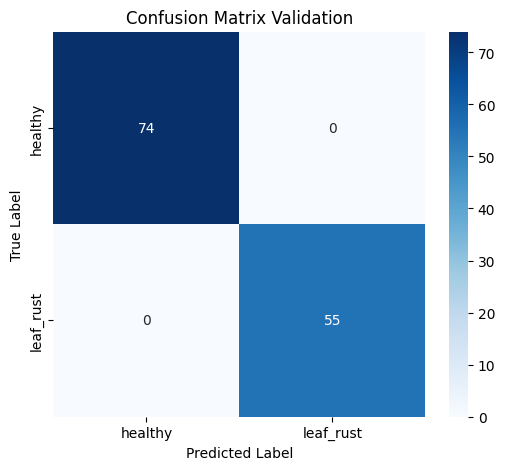

In [32]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Validation')
plt.savefig('Confusion Matrix Validation.png')
plt.show()

In [33]:
TEST_DIR = ROOT / "test"

test_dataset = datasets.ImageFolder(root=str(TEST_DIR))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [34]:
model_eval = YOLO(f"{PROJECT}/{best_fold}/weights/best.pt")

In [35]:
# Run inference on test images
from PIL import Image
preds, gts = [], []
test_images = []

for img_path, gt in test_dataset.samples:
    result = model.predict(img_path, imgsz=224, verbose=False)

    pred = int(result[0].probs.top1)
    preds.append(pred)
    gts.append(gt)

    if len(test_images) < 5:  # Save a few images for logging
        img = Image.open(img_path).convert("RGB")
        test_images.append((img, gt, pred))

In [36]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(gts, preds)
cm = confusion_matrix(gts, preds)
auc = roc_auc_score(gts, [1 if p == 1 else 0 for p in preds])  # For binary class

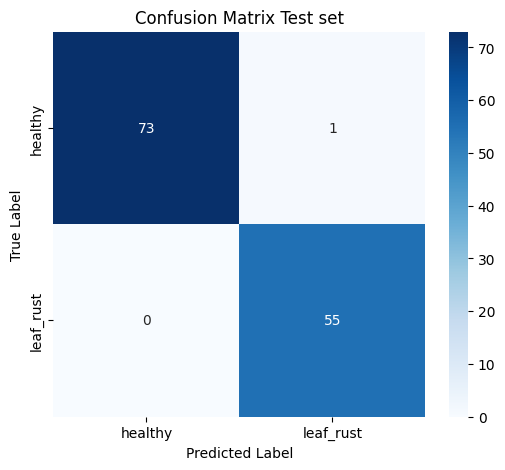

In [37]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test set')
plt.savefig('Confusion Matrix Test.png')
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("For the val set:")
print(f"Accuracy: {acc_val}")
print(f"Precision(weighted): {precision_score(val_gts, val_preds,average='weighted')}")
print(f"Precision: {precision_score(val_gts, val_preds)}")
print(f"Recall(weighted): {recall_score(val_gts, val_preds,average='weighted')}")
print(f"Recall: {recall_score(val_gts, val_preds)}")
print(f"F1 score(weighted): {f1_score(val_gts, val_preds,average='weighted')}")
print(f"F1 score: {f1_score(val_gts, val_preds)}")

For the val set:
Accuracy: 1.0
Precision(weighted): 1.0
Precision: 1.0
Recall(weighted): 1.0
Recall: 1.0
F1 score(weighted): 1.0
F1 score: 1.0


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("For the test set:")
print(f"Accuracy: {acc}")
print(f"Precision(weighted): {precision_score(gts, preds,average='weighted')}")
print(f"Precision: {precision_score(gts, preds)}")
print(f"Recall(weighted): {recall_score(gts, preds,average='weighted')}")
print(f"Recall: {recall_score(gts, preds)}")
print(f"F1 score(weighted): {f1_score(gts, preds,average='weighted')}")
print(f"F1 score: {f1_score(gts, preds)}")

For the test set:
Accuracy: 0.9922480620155039
Precision(weighted): 0.9923864894795127
Precision: 0.9821428571428571
Recall(weighted): 0.9922480620155039
Recall: 1.0
F1 score(weighted): 0.9922566135190719
F1 score: 0.990990990990991


In [40]:
print(f"gts: {gts}")
print(f"val_gts: {val_gts}")
print(f"preds: {preds}")
print(f"val_preds: {val_preds}")

gts: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
val_gts: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [41]:
print(auc)

0.9932432432432433


In [42]:
top1_scores

[1.0, 0.9833333492279053, 1.0, 1.0, 1.0]

In [43]:
!zip -r runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/kfold_wheat_leaf_rust/ (stored 0%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/ (stored 0%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/val_batch1_labels.jpg (deflated 42%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/results.png (deflated 9%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/confusion_matrix_normalized.png (deflated 34%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/val_batch2_labels.jpg (deflated 40%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/val_batch0_labels.jpg (deflated 41%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/val_batch1_pred.jpg (deflated 42%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/args.yaml (deflated 52%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/confusion_matrix.png (deflated 35%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/results.csv (deflated 64%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/weights/ (stored 0%)
  adding: runs/kfold_wheat_leaf_rust/fold_2/weights/last.pt (deflated 9%)
  adding: runs/kfold_wh

In [44]:
!zip -r wandb.zip wandb/

  adding: wandb/ (stored 0%)
  adding: wandb/debug.log (deflated 90%)
  adding: wandb/run-20250612_215543-lef02cp8/ (stored 0%)
  adding: wandb/run-20250612_215543-lef02cp8/tmp/ (stored 0%)
  adding: wandb/run-20250612_215543-lef02cp8/tmp/code/ (stored 0%)
  adding: wandb/run-20250612_215543-lef02cp8/logs/ (stored 0%)
  adding: wandb/run-20250612_215543-lef02cp8/logs/debug.log (deflated 90%)
  adding: wandb/run-20250612_215543-lef02cp8/logs/debug-core.log (deflated 58%)
  adding: wandb/run-20250612_215543-lef02cp8/logs/debug-internal.log (deflated 87%)
  adding: wandb/run-20250612_215543-lef02cp8/files/ (stored 0%)
  adding: wandb/run-20250612_215543-lef02cp8/files/requirements.txt (deflated 54%)
  adding: wandb/run-20250612_215543-lef02cp8/files/wandb-metadata.json (deflated 44%)
  adding: wandb/run-20250612_215543-lef02cp8/files/output.log (deflated 92%)
  adding: wandb/run-20250612_215543-lef02cp8/files/media/ (stored 0%)
  adding: wandb/run-20250612_215543-lef02cp8/files/media/imag

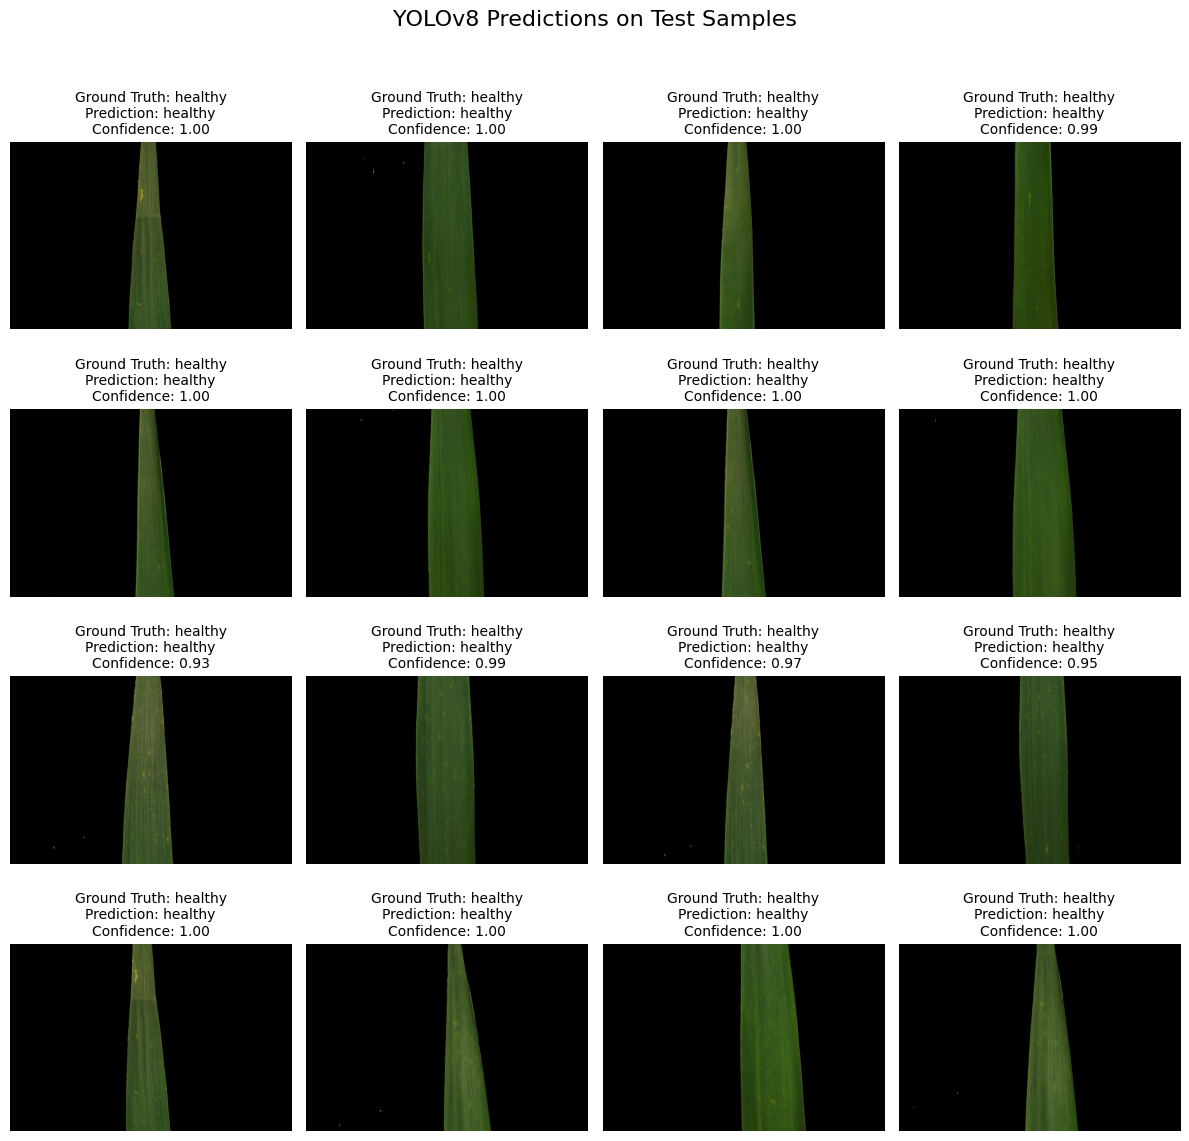

In [47]:
import matplotlib.pyplot as plt
from PIL import Image

# Prepare lists for storing info
test_samples = []  # will store (image, gt, pred, confidence)

# Run inference on first 16 samples
for i, (img_path, gt) in enumerate(test_dataset.samples[:16]):
    result = model.predict(img_path, imgsz=224, verbose=False)

    pred = int(result[0].probs.top1)
    conf = float(result[0].probs.top1conf)  # max probability = confidence

    img = Image.open(img_path).convert("RGB")
    test_samples.append((img, gt, pred, conf))

# Plotting the 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("YOLOv8 Predictions on Test Samples", fontsize=16)

for idx, (img, gt, pred, conf) in enumerate(test_samples):
    ax = axes[idx // 4, idx % 4]
    ax.imshow(img)
    ax.axis("off")
    title = f"Ground Truth: {CLASSES[gt]}\nPrediction: {CLASSES[pred]}\nConfidence: {conf:.2f}"
    ax.set_title(title, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Sample Predictions.png")
plt.show()
